In [2]:
import os
import pickle
import tarfile
import datetime
import numpy as np
import urllib.request
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except:
        print('GPU not enable')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


In [4]:
%load_ext tensorboard

In [5]:
HISTORY_DIR = 'C:/Users/dmitry/Desktop/Jupiter/dvfu_tasks/history'
os.makedirs(HISTORY_DIR, exist_ok=True)

In [6]:
def get_data():
    if not os.path.exists('cifar-10-batches-py/'):
        urllib.request.urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz', 'cifar-10-python.tar.gz')
        file = tarfile.open('cifar-10-python.tar.gz', 'r:gz')
        file.extractall()
        
    X, y = [], []
    for i in range(1, 6):
        d = pickle.load(open(os.path.join('cifar-10-batches-py', f'data_batch_{i}'), 'rb'), encoding='bytes')
        X.append(d[b'data'])
        y.append(d[b'labels'])
        
    d = pickle.load(open(os.path.join('cifar-10-batches-py', 'test_batch'), 'rb'), encoding='bytes')
        
    return (
        np.concatenate(X, axis=0).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.concatenate(y, axis=0),
        pickle.load(open('cifar-10-batches-py/batches.meta', 'rb'))['label_names'],
        np.array(d[b'data']).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1),
        np.array(d[b'labels'])
    )

In [7]:
def plot_confusion_matrix(model: tf.keras.models.Model, X: np.ndarray, y: np.ndarray, labels: list[str], batch_size: int = 64, **kwargs):
    _, ax = plt.subplots(figsize=(10, 10))
    sklearn.metrics.ConfusionMatrixDisplay.from_predictions(
        y,
        model.predict(X.reshape(-1, 32, 32, 3) / 255, verbose=False, batch_size=batch_size).argmax(axis=-1),
        display_labels=labels,
        xticks_rotation='vertical',
        ax=ax,
        **kwargs
    )

In [8]:
X, y, labels, X_test, y_test = get_data()

In [9]:
train_data = tf.data.Dataset.from_tensor_slices(X).map(lambda x: tf.cast(tf.reshape(x, (32, 32, 3)) / 255, tf.float32))
train_labels = tf.data.Dataset.from_tensor_slices(y)
train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(64)

val_data = tf.data.Dataset.from_tensor_slices(X_test).map(lambda x: tf.cast(tf.reshape(x, (32, 32, 3)) / 255, tf.float32))
val_labels = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(64)

In [20]:
inputs = tf.keras.layers.Input((32, 32, 3), name='input_layer')
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', name='conv_layer1')(inputs)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', name='conv_layer2')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(2, name='maxpool_layer1')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Conv2D(64, 3, padding='same', name='conv_layer3')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(64, 3, padding='same', name='conv_layer4')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)

x = tf.keras.layers.MaxPooling2D(2, name='maxpool_layer2')(x)
x = tf.keras.layers.Dropout(0.3)(x)

x = tf.keras.layers.Conv2D(128, 3, padding='same', name='conv_layer5')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Conv2D(128, 3, padding='same', name='conv_layer6')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.MaxPooling2D(2, name='maxpool_layer3')(x)
x = tf.keras.layers.Dropout(0.4)(x)

x = tf.keras.layers.ReLU()(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Dropout(0.5)(x)

x = tf.keras.layers.Dense(10, activation='softmax')(x)




model = tf.keras.Model(inputs=inputs, outputs=x)


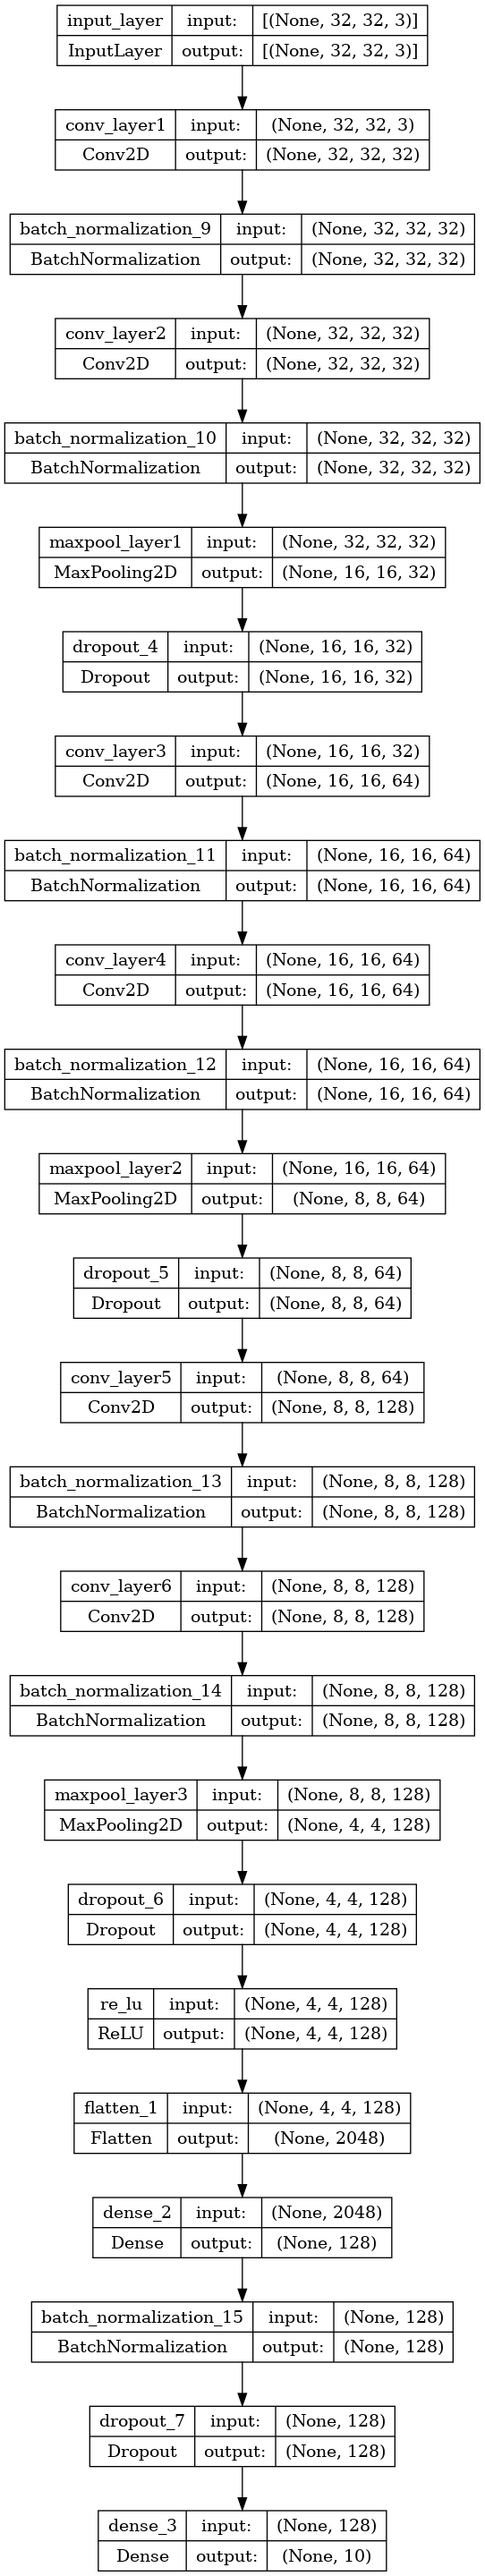

In [46]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [21]:
model = tf.keras.Model(inputs=inputs, outputs=x, name='ciaonima-10')

In [22]:
model.summary()

Model: "ciaonima-10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 conv_layer1 (Conv2D)        (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv_layer2 (Conv2D)        (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_10 (Bat  (None, 32, 32, 32)       128       
 chNormalization)                                                
                                                                 
 maxpool_layer1 (MaxPooling2  (None, 16, 16, 32)       

In [23]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy', optimizer='adam')

In [24]:
logdir = os.path.join(HISTORY_DIR, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [25]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(logdir, 'model'),
    save_best_only=True
)

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    os.path.join(logdir, 'logs'),
    write_graph=True   
)

In [47]:
%tensorboard --logdir $logdir

In [41]:
model.fit(train_dataset, validation_data=val_dataset, epochs=85, callbacks=[model_checkpoint_callback, tensorboard_callback])

Epoch 1/85
782/782 [==============================] - 9s 12ms/step - loss: 0.3076 - accuracy: 0.8909 - val_loss: 0.5247 - val_accuracy: 0.8310
Epoch 2/85
782/782 [==============================] - 9s 12ms/step - loss: 0.3090 - accuracy: 0.8912 - val_loss: 0.4872 - val_accuracy: 0.8456
Epoch 3/85
782/782 [==============================] - 9s 12ms/step - loss: 0.3099 - accuracy: 0.8909 - val_loss: 0.4532 - val_accuracy: 0.8542
Epoch 4/85
782/782 [==============================] - 10s 12ms/step - loss: 0.3085 - accuracy: 0.8924 - val_loss: 0.4736 - val_accuracy: 0.8481
Epoch 5/85
782/782 [==============================] - 9s 11ms/step - loss: 0.3135 - accuracy: 0.8892 - val_loss: 0.5043 - val_accuracy: 0.8433
Epoch 6/85
782/782 [==============================] - 9s 11ms/step - loss: 0.3045 - accuracy: 0.8918 - val_loss: 0.4966 - val_accuracy: 0.8420
Epoch 7/85
782/782 [==============================] - 10s 13ms/step - loss: 0.3054 - accuracy: 0.8934 - val_loss: 0.4781 - val_accuracy: 0.85

KeyboardInterrupt: 

In [42]:
y_pred = model.predict(X_test.reshape(-1, 32, 32, 3) / 255, verbose=False).argmax(axis=-1)

In [56]:
(X_test.reshape(-1, 32, 32, 3) / 255).shape

(10000, 32, 32, 3)

In [43]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(10)])

0.8513000000000002

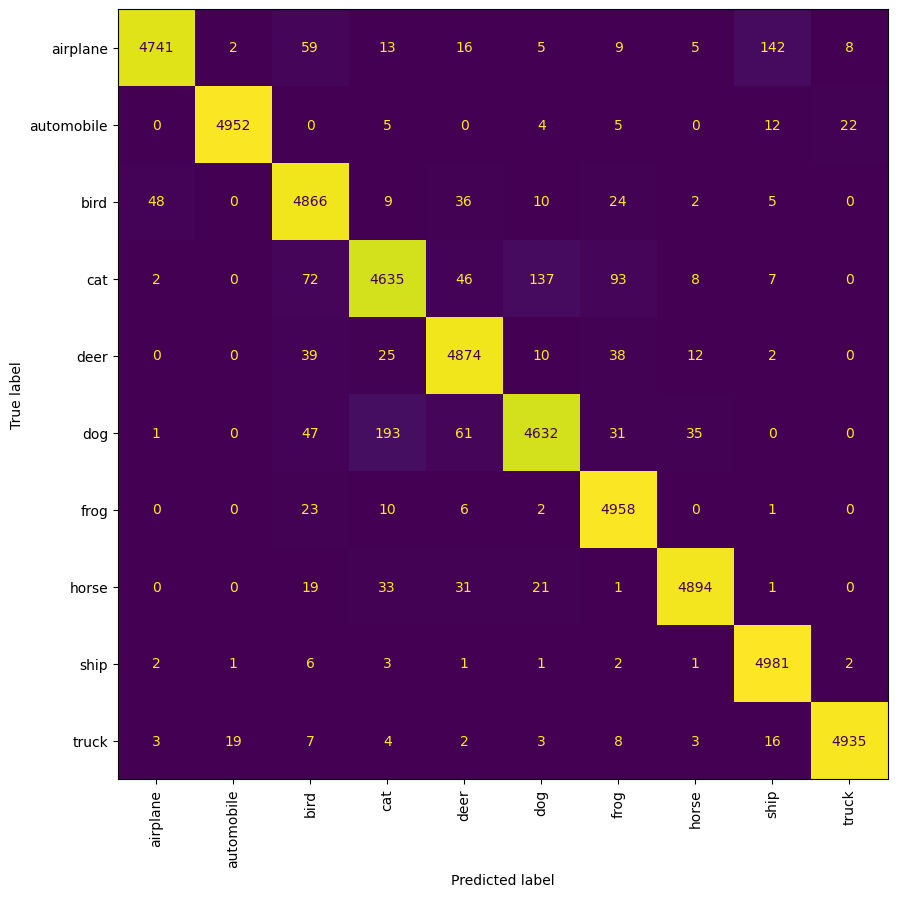

In [44]:
plot_confusion_matrix(model, X, y, labels=labels, colorbar=False)

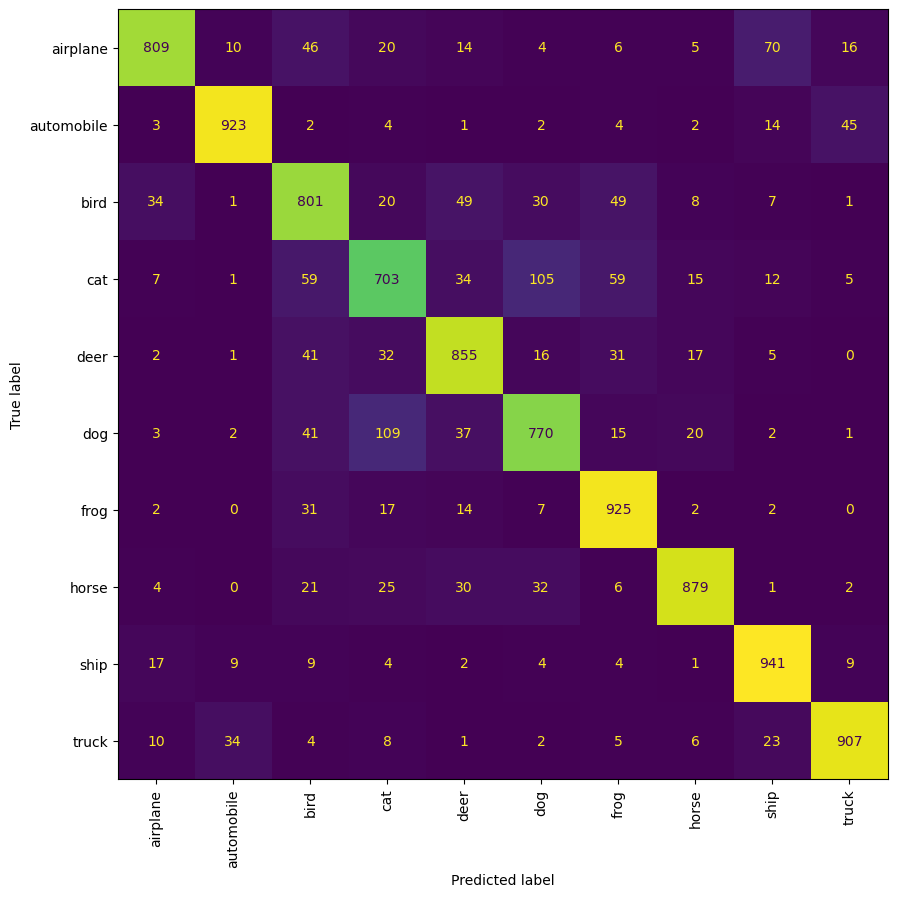

In [45]:
plot_confusion_matrix(model, X_test, y_test, labels=labels, colorbar=False)